# Calcul des probabilités et théorie des erreurs - Projet

## Table des matières

* [Introduction](#Introduction)

## Introduction
La question 6 concerne l'inversion d'une matrice en utilisant un réseau de noeuds. Cette opération est réalisée de deux manière différentes :
* Avec les noeuds en série
* Avec les noeuds en parallèle

Le temps nécessaire pour effectuer cette opération est mesuré et groupé en fonction de la taille de la matrice.


## Initialisation

In [502]:
from collections import defaultdict
import numpy
import matplotlib.pyplot as plot
import scipy.stats as stats
import math

def normalize(f):
    return '{:0.5f}'.format(f)

ALPHA = 0.05

## Lire les échantillons
Le fichier '.dat' fournit contient un tableau en trois colonnes :
1. La taille des matrices exprimée en nombre de lignes
2. Le temps mesuré lors d'un travail en série
3. le temps mesuré lors d'un travail en parallèle

Ces données seront stockées dans un dictionnaire de la forme suivante :
* Clés : Tailles des matrices (50, 150, ..., 950)
* Valeurs : Tuple contenant deux listes, la première contient les temps mesurés en série et la seconde les temps mesurés en parallèle




In [503]:
def load_file(name):
    samples = defaultdict(lambda: ([], []))
    with open(name) as file:
        for l in file:
            values = list(map(float, l.split()))
            size = int(values[0])
            times = values[1:]
            for i in range(2):
                samples[size][i].append(times[i])
        for size, times in samples.items():
            times[0].sort()
            times[1].sort()
        return samples

SAMPLES = load_file("Q6_donnee.dat")


## Aperçus des données fournies

Un premier graphique sous la forme d'un nuage de points parait un bon point de départ.
En effet, il permet d'avoir un premier aperçu du comportement des deux techniques en fonction de la taille des matrices.




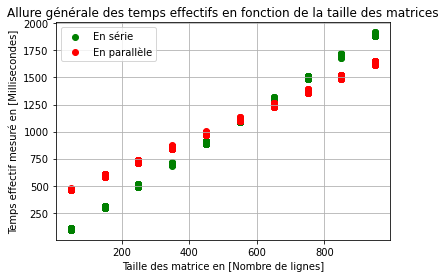

In [504]:
def overview_of_data():
    x = []
    y1 = []
    y2 = []
    for size, times in SAMPLES.items():
        for t1, t2 in zip(times[0], times[1]):
                x.append(size)
                y1.append(t1)
                y2.append(t2)
    plot.scatter(x, y1, c='green', label='En série')
    plot.scatter(x, y2, c='red', label='En parallèle')
    plot.legend()
    plot.grid(True)
    plot.title('Allure générale des temps effectifs en fonction de la taille des matrices')
    plot.xlabel('Taille des matrice en [Nombre de lignes]')
    plot.ylabel('Temps effectif mesuré en [Millisecondes]')
    plot.show()


overview_of_data()

Au vue de ce graphique, il est possible de tirer de premières conclusions :
* Dans les deux cas, le temps nécessaire augmente de proportionnellement avec la taille de la matrice
* Quand la taille est petite ($< \pm 550$), le travail en série semble plus performant que le travail en parallèle
* Par la suite, la situation s'inverse


## Allure générale des échantillons
Il est possible d'observer l'allure générale des échantillons via la construction d'histogramme.
Les échantillons sont répartis en sous-groupe en fonction de la taille de la matrice.
Chaque sous-groupe contient trois histogrammes :
* Le premier permet de visualiser les deux techniques sur le même graphes
* Le second fournit une vue centrée sur le travail en série
* Le dernier fournit une vue centrée sur le travail en parallèle

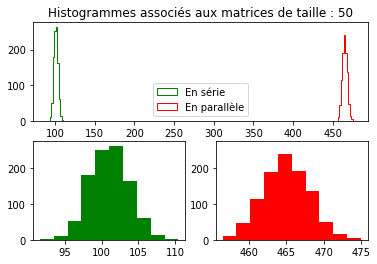

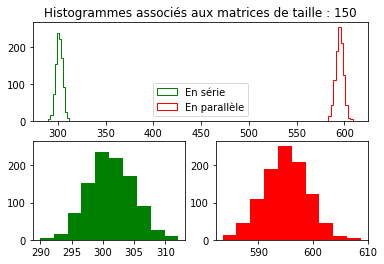

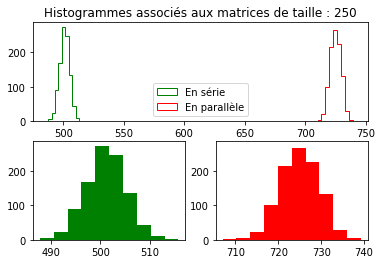

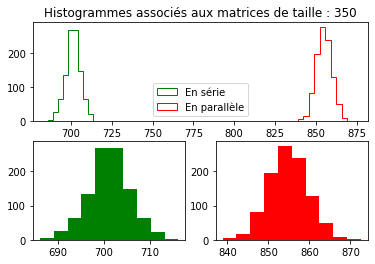

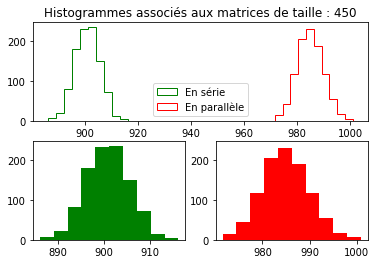

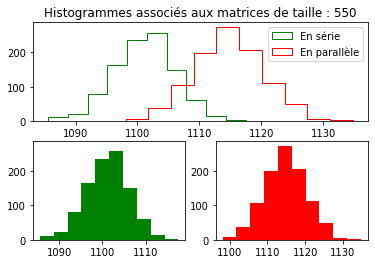

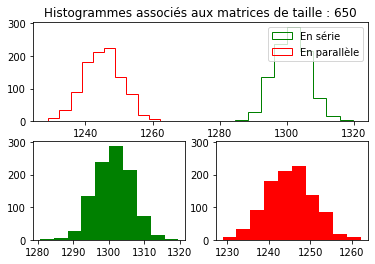

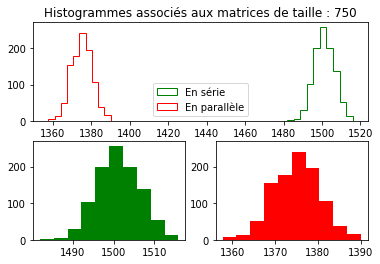

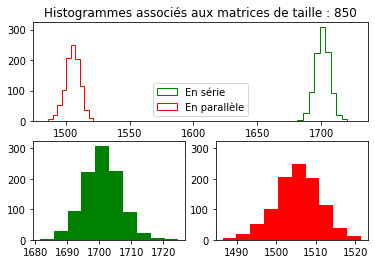

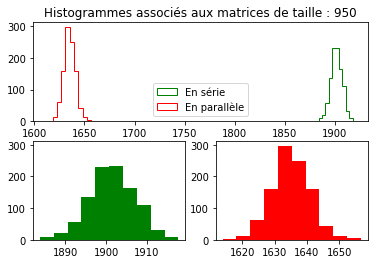

In [505]:
def construct_histo():
    for size, times in SAMPLES.items():
        serial = []
        parallel = []
        for t1, t2 in zip(times[0], times[1]):
            serial.append(t1)
            parallel.append(t2)
        fig = plot.figure()
        grid = fig.add_gridspec(nrows=2, ncols=2)
        up = fig.add_subplot(grid[:-1, :])
        down_left = fig.add_subplot(grid[-1, :-1])
        down_right = fig.add_subplot(grid[-1, -1], sharey=down_left)
        up.hist(serial, color='green', label='En série', histtype='step')
        up.hist(parallel, color='red', label='En parallèle', histtype='step')
        up.set_title('Histogrammes associés aux matrices de taille : ' + str(size))
        down_left.hist(serial, color='green')
        down_right.hist(parallel, color='red')
        up.legend()

construct_histo()

Ces histogrammes permettent de tirer de nouvelles conclusions et d'en confirmer d'autres :
* Pour de petites matrices, la technique en série semble meilleure que la technique en parallèle
Par contre, la situation s'inverse ensuite.
* Dans les deux cas, les échantillons paraissent suivre une loi normale.
* Grâce au premier graphique de chaque sous-groupe, il est possible de constater que les moyennes sont différentes.
* Les variances paraissent, à première vue, équivalentes.


## Calculer les moyennes et les variances
Par la suite du projet, il sera nécessaire d'obtenir la moyenne et la variance d'un sensmble de données.
Donc voici deux fonctions permettant de calculer la moyenne empirique et la variance non biaisée.
Pour rappel, dans le cas d'estimateurs non biaisés la moyenne non biaisée est égale à la moyenne empirique.

In [506]:
def empirical_mean(data):
    return sum(data) / len(data)

def unbiased_variance(data):
    res_sum = 0
    xn = empirical_mean(data)
    for x in data:
        res_sum += (x - xn)**2
    return res_sum / (len(data) - 1)

## Test d'adéquation

L'hypothèse nulle est que les échantillons suivent une loi normale ou de Gauss.
Les échantillons fournis concernent des variables continues.
C'est pourquoi l'utilisation du test de Kolmogorov-Smirnov parait le plus adéquat.

In [507]:
def kolmogorov_smirnov_test():
    res = defaultdict(lambda: [float, float, bool, bool])
    for size, times in SAMPLES.items():
        max_val = 0
        for i in range(2):
            f_th = 0
            data = times[i]
            n = len(data)
            xn = empirical_mean(data)
            var = unbiased_variance(data)
            k_s = get_threshold(n)
            for value in data:
                f_n = get_f_n(value, xn, math.sqrt(var))
                f_th += 1 / n
                sub = abs(f_n - f_th)
                max_val = max(max_val, sub)
            res[size][i] = max_val
            res[size][i+2] = max_val < k_s
    return res

def get_threshold(n):
    switcher = {
        0.2 : 1.073,
        0.1 : 1.223,
        0.05 : 1.358,
        0.02 : 1.518,
        0.01 : 1.629
    }
    return switcher[ALPHA]/math.sqrt(n)

def get_f_n(value, xn, sigma):
    normalized = (value - xn) / sigma
    return stats.norm.cdf(normalized)

def print_test_ks():
    test_ks = kolmogorov_smirnov_test()
    builder = " N |   En série   | En parallèle\n"
    builder += "___________________________________\n"
    for size, times in SAMPLES.items():
        builder += str(size)
        builder += " | "
        builder += str(normalize(test_ks[size][0]))
        builder += " "
        builder += str(test_ks[size][2])
        builder += " | "
        builder += str(normalize(test_ks[size][1]))
        builder += " "
        builder += str(test_ks[size][3])
        builder += "\n___________________________________\n"
    print(builder)

print("Test de Kolmogorov-Smirnov avec un alpha de " + str(ALPHA*100) + " %")
print_test_ks()

Test de Kolmogorov-Smirnov avec un alpha de 5.0 %
 N |   En série   | En parallèle
___________________________________
50 | 0.02230 True | 0.02230 True
___________________________________
150 | 0.01960 True | 0.01960 True
___________________________________
250 | 0.02239 True | 0.02239 True
___________________________________
350 | 0.02527 True | 0.02527 True
___________________________________
450 | 0.01271 True | 0.02543 True
___________________________________
550 | 0.02555 True | 0.02555 True
___________________________________
650 | 0.01600 True | 0.01874 True
___________________________________
750 | 0.02471 True | 0.02471 True
___________________________________
850 | 0.01359 True | 0.01988 True
___________________________________
950 | 0.01620 True | 0.01828 True
___________________________________



Le test de Kolmogorv-Smirnov est appliqué pour chaque taille de matrice et aux deux techniques.
Dans tous les cas, il est réussi. Donc les échantillons suivent une loi normale.

## Tests d'équivalence
Maintenant, il faut tester l'équivalence des moyennes ainsi que l'équivalence des variances entre les deux techniques.


### Test de Fisher
Le but de ce test est de vérifier l'équivalence des variances des deux algorithmes.
Il est à appliquer pour chaque taille de matrice.

In [508]:
def fisher_test():
    res = defaultdict()
    for size, times in SAMPLES.items():
        serial_data = times[0]
        n = len(serial_data)
        parallel_data = times[1]
        m = len(parallel_data)
        serial_var = unbiased_variance(serial_data)
        parallel_var = unbiased_variance(parallel_data)
        z = (n / (n - 1)) * serial_var / (m / (m - 1)) *  parallel_var
        if serial_var <= parallel_var:
            z = 1/z
        test = z < stats.f.ppf(ALPHA/2, n-1, m-1)
        res[size] = [serial_var, parallel_var, z, test]
    return res

def print_test_fisher():
    test_fisher = fisher_test()
    builder = " N  |      Variances      |   Z    | Rés \n"
    builder += "    |  Série   |   Par    |        | \n"
    builder += "___________________________________________\n"
    for size, times in SAMPLES.items():
        builder += str(size)
        builder += " | "
        builder += str(normalize(test_fisher[size][0]))
        builder += " | "
        builder += str(normalize(test_fisher[size][1]))
        builder += " | "
        builder += str(normalize(test_fisher[size][2]))
        builder += " | "
        builder += str(test_fisher[size][3])
        builder += "\n___________________________________________\n"
    print(builder)

print_test_fisher()


 N  |      Variances      |   Z    | Rés 
    |  Série   |   Par    |        | 
___________________________________________
50 | 6.82051 | 9.17421 | 0.01598 | True
___________________________________________
150 | 12.42410 | 16.00747 | 0.00503 | True
___________________________________________
250 | 16.77835 | 19.55174 | 0.00305 | True
___________________________________________
350 | 20.21081 | 22.68524 | 0.00218 | True
___________________________________________
450 | 21.77794 | 24.43889 | 0.00188 | True
___________________________________________
550 | 24.48296 | 30.65197 | 0.00133 | True
___________________________________________
650 | 26.28722 | 31.78537 | 0.00120 | True
___________________________________________
750 | 27.65361 | 29.53000 | 0.00122 | True
___________________________________________
850 | 32.76665 | 32.98573 | 0.00093 | True
___________________________________________
950 | 32.28084 | 34.12907 | 0.00091 | True
___________________________________________



Le test de Fosher est réussi pour l'ensemble des échantillons donc les variances sont équivalentes quelque soit la taille de la matrice.

### Test t de Student
L'hypothèse nulle est l'équivalence des moyennes.

In [509]:
print(stats.ttest_ind(SAMPLES[50][0], SAMPLES[50][1]))

'''
#retourne le resultat du test de moyenne
def confidence_interval_test(samples):
	result = defaultdict(dict)
	for size, algs in samples.items():
		to_comp = [(i, j) for i in range(3) for j in range(i + 1, 3)]
		for (alg1, alg2) in to_comp:
			data1 = algs[alg1]
			data2 = algs[alg2]
			n1 = len(data1)
			n2 = len(data2)
			num = abs(mean(data1) - mean(data2))
			den = math.sqrt((variance(data1)**2 / n1) + \
						            (variance(data2)**2 / n2))
			test = num / den
			Z = 1.96 #distribution normale standard d ordre 1 - 0.05/2
			#a decommenter pour resultat du test de moyenne
			#print(test)
			compatible = test > Z
			result[size][(alg1, alg2)] = compatible
	return result
'''

Ttest_indResult(statistic=-2878.027806483095, pvalue=0.0)


'\n#retourne le resultat du test de moyenne\ndef confidence_interval_test(samples):\n\tresult = defaultdict(dict)\n\tfor size, algs in samples.items():\n\t\tto_comp = [(i, j) for i in range(3) for j in range(i + 1, 3)]\n\t\tfor (alg1, alg2) in to_comp:\n\t\t\tdata1 = algs[alg1]\n\t\t\tdata2 = algs[alg2]\n\t\t\tn1 = len(data1)\n\t\t\tn2 = len(data2)\n\t\t\tnum = abs(mean(data1) - mean(data2))\n\t\t\tden = math.sqrt((variance(data1)**2 / n1) + \t\t\t\t\t\t            (variance(data2)**2 / n2))\n\t\t\ttest = num / den\n\t\t\tZ = 1.96 #distribution normale standard d ordre 1 - 0.05/2\n\t\t\t#a decommenter pour resultat du test de moyenne\n\t\t\t#print(test)\n\t\t\tcompatible = test > Z\n\t\t\tresult[size][(alg1, alg2)] = compatible\n\treturn result\n'

Retourner le résultat du test de Fisher

In [510]:
'''
def fisher_test(samples):
	result = defaultdict(dict)
	for size, algs in samples.items():
		to_comp = [(i, j) for i in range(3) for j in range(i + 1, 3)]
		for (alg1, alg2) in to_comp:
			data1 = algs[alg1]
			data2 = algs[alg2]
			variance1 = variance(data1)
			variance2 = variance(data2)
			n1 = len(data1)
			n2 = len(data2)
			num = (n1 / (n1 - 1)) * variance1
			den = (n2 / (n2 - 1)) * variance2
			T = num / den
			if variance1 <= variance2:
				T = 1 / T
			F = 1.48 # Fisher-Snedecor with v1 = 100 and v2 = 100 and order 0.05/2
			#a decommenter pour resultat du test de Fisher
			#print(T)
			compatible = T < F
			result[size][(alg1, alg2)] = compatible
	return result
'''

'\ndef fisher_test(samples):\n\tresult = defaultdict(dict)\n\tfor size, algs in samples.items():\n\t\tto_comp = [(i, j) for i in range(3) for j in range(i + 1, 3)]\n\t\tfor (alg1, alg2) in to_comp:\n\t\t\tdata1 = algs[alg1]\n\t\t\tdata2 = algs[alg2]\n\t\t\tvariance1 = variance(data1)\n\t\t\tvariance2 = variance(data2)\n\t\t\tn1 = len(data1)\n\t\t\tn2 = len(data2)\n\t\t\tnum = (n1 / (n1 - 1)) * variance1\n\t\t\tden = (n2 / (n2 - 1)) * variance2\n\t\t\tT = num / den\n\t\t\tif variance1 <= variance2:\n\t\t\t\tT = 1 / T\n\t\t\tF = 1.48 # Fisher-Snedecor with v1 = 100 and v2 = 100 and order 0.05/2\n\t\t\t#a decommenter pour resultat du test de Fisher\n\t\t\t#print(T)\n\t\t\tcompatible = T < F\n\t\t\tresult[size][(alg1, alg2)] = compatible\n\treturn result\n'

Afficher .......

In [511]:
'''
#affiche la compatibilité entre les algo
def show_compatibility(samples):
	confidence_interval = confidence_interval_test(samples)
	fisher = fisher_test(samples)
	for size in samples:
		print('- Size : ' + str(size))
		to_comp = [(i, j) for i in range(2) for j in range(i + 1, 3)]
		for (alg1, alg2) in to_comp:
			compatible_mean = confidence_interval[size][(alg1, alg2)]
			compatible_variance = fisher[size][(alg1, alg2)]
			compatible = compatible_variance and compatible_mean
			print('    Algos ' + str(alg1 + 1) + ' and ' + str(alg2 + 1) + \
			    ' : (' + str(compatible_mean) + ', ' + \
				 str(compatible_variance) + ') => ' + str(compatible))
'''

"\n#affiche la compatibilité entre les algo\ndef show_compatibility(samples):\n\tconfidence_interval = confidence_interval_test(samples)\n\tfisher = fisher_test(samples)\n\tfor size in samples:\n\t\tprint('- Size : ' + str(size))\n\t\tto_comp = [(i, j) for i in range(2) for j in range(i + 1, 3)]\n\t\tfor (alg1, alg2) in to_comp:\n\t\t\tcompatible_mean = confidence_interval[size][(alg1, alg2)]\n\t\t\tcompatible_variance = fisher[size][(alg1, alg2)]\n\t\t\tcompatible = compatible_variance and compatible_mean\n\t\t\tprint('    Algos ' + str(alg1 + 1) + ' and ' + str(alg2 + 1) + \t\t\t    ' : (' + str(compatible_mean) + ', ' + \t\t\t\t str(compatible_variance) + ') => ' + str(compatible))\n"

Lancer l'application

In [512]:
'''
samples = load_samples()

show_data_overview(samples)
show_hists(samples)
show_kolmogorov_smirnov_test(samples)
show_compatibility(samples)
'''

'\nsamples = load_samples()\n\nshow_data_overview(samples)\nshow_hists(samples)\nshow_kolmogorov_smirnov_test(samples)\nshow_compatibility(samples)\n'